In [26]:
import os 
import glob
join = os.path.join
from djccx.read_dat import read_dat
import numpy as np
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt


In [27]:
params_composite ={
    "r"         :  0.25,
    "h"         :  0.65,
    "z0"        :  2.82/2,
    "density"   : 8,
    "interface_factor"  :  1.2,
    "with_interface"    : False,
    "mirror"            : True,
    "check_jacobian"    : False,
}

params_ccx = {
    "epsilon" : 0.1,
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [28]:
def compute_vol_frac(dat_path):
    dat = read_dat(dat_path)
    vols = [ idat["df"]["volume"].sum() for idat in dat]
    vT = vols[1]
    v_yarns = vols[0]/vT
    v_matrix = 1 - v_yarns 
    return {
        "yarns"  : v_yarns,
        "matrix" : v_matrix,
    }

In [29]:
r_span = np.linspace(0.15 ,0.25,3)
r_span

array([0.15, 0.2 , 0.25])

In [30]:
frd_files = glob.glob(join("output","r_*","ccx","*","*.frd"),recursive=True)
dat_files = glob.glob(join("output","r_*","ccx","*","*.dat"),recursive=True)

In [31]:
designs = [ os.path.split(os.path.split(f)[0])[1] for f in frd_files]
designs = list(designs)
designs

['SX', 'SY', 'X', 'Y', 'SX', 'SY', 'X', 'Y', 'SX', 'SY', 'X', 'Y']

In [32]:
ancho = params_composite["z0"] + 0.5*params_composite["h"]
largo = 10 
A = ancho*largo

def compute_Fapl(iffiles):
    ifrd = readfrd(iffiles)
    df = ifrd["data"]
    Fapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))

    return Fapl

Fapl = [compute_Fapl(f) for f in frd_files]
Sapl = [f/A for f in Fapl]
E_eff = [s / params["ccx"]["epsilon"] for s in Sapl]

In [33]:
vfracs = [compute_vol_frac(f) for f in dat_files]

In [34]:
vfracs

[{'yarns': np.float64(0.03180902794976575),
  'matrix': np.float64(0.9681909720502343)},
 {'yarns': np.float64(0.03180902795580407),
  'matrix': np.float64(0.9681909720441959)},
 {'yarns': np.float64(0.06524139316415482),
  'matrix': np.float64(0.9347586068358452)},
 {'yarns': np.float64(0.06524132456254564),
  'matrix': np.float64(0.9347586754374544)},
 {'yarns': np.float64(0.05655069011265088),
  'matrix': np.float64(0.9434493098873491)},
 {'yarns': np.float64(0.05655068995855535),
  'matrix': np.float64(0.9434493100414446)},
 {'yarns': np.float64(0.11598612516218237),
  'matrix': np.float64(0.8840138748378177)},
 {'yarns': np.float64(0.11598631478463348),
  'matrix': np.float64(0.8840136852153665)},
 {'yarns': np.float64(0.08836308107206003),
  'matrix': np.float64(0.91163691892794)},
 {'yarns': np.float64(0.0883630810396541),
  'matrix': np.float64(0.9116369189603459)},
 {'yarns': np.float64(0.18123000351800572),
  'matrix': np.float64(0.8187699964819943)},
 {'yarns': np.float64(0.

In [35]:
from validation.experimental import carbonfiber,resina,nucleo

carbon = carbonfiber()
Ecarbon_MPa = carbon["carbon"].iloc[0]["Young Modulus (GPa)"]*1e3
resina = resina()
nucleo = nucleo()

In [36]:
def analytical(r):
    v_y  = r["yarns"]
    v_m  = r["matrix"]

    E_y = Ecarbon_MPa
    E_m = resina["young modulus [MPa]"]

    E_sy = 1/(v_y/E_y + v_m/E_m)
    v_sy = v_y + v_m
    return  E_sy*v_sy 

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [37]:
E_y = Ecarbon_MPa
E_m = resina["young modulus [MPa]"]
E_a = nucleo["young modulus [MPa]"]

In [38]:
print("Carbon",Ecarbon_MPa)
print("Resina",resina["young modulus [MPa]"])
print("Nucleo",nucleo["young modulus [MPa]"])

Carbon 230000.0
Resina 2549.7289999999994
Nucleo 800


In [39]:
v_carbon = np.array(v_carbon)

In [40]:
E_eff = np.array(E_eff)
E_eff_analytical = np.array(E_eff_analytical)

In [41]:
v_carbon

array([0.03180903, 0.03180903, 0.06524139, 0.06524132, 0.05655069,
       0.05655069, 0.11598613, 0.11598631, 0.08836308, 0.08836308,
       0.18123   , 0.18122999])

In [42]:
import pandas as pd

In [43]:
designs

['SX', 'SY', 'X', 'Y', 'SX', 'SY', 'X', 'Y', 'SX', 'SY', 'X', 'Y']

In [44]:
df_results = pd.DataFrame({ 
    "design" : designs,
    "v_carbon" : v_carbon,
    "E_eff" : E_eff,
})

In [48]:
df_results

,design,v_carbon,E_eff
0,SX,0.031809,1156.956433
1,SY,0.031809,1122.221233
2,X,0.065241,1104.976133
3,Y,0.065241,6514.656378
4,SX,0.056551,1229.909124
5,SY,0.056551,1191.175780
6,X,0.115986,1189.371566
7,Y,0.115986,10838.776862
8,SX,0.088363,1304.066610
9,SY,0.088363,1270.164992


Text(0.5, 0, 'Carbon volume fraction (%)')

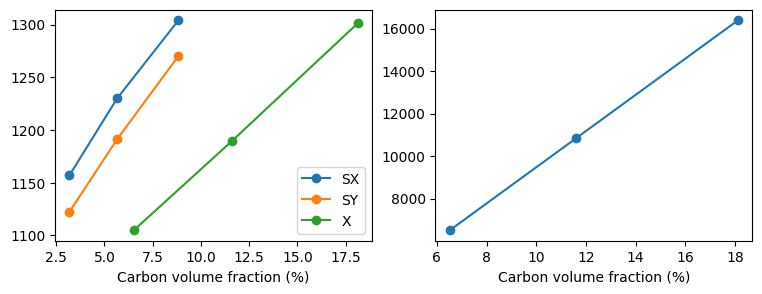

In [ ]:
desing_unique = df_results["design"].unique()
fig = plt.figure(figsize=(9,3))
#
plt.subplot(1,2,1)
for d in ["SX","SY","X"]:
    df = df_results[df_results["design"] == d]
    plt.plot(100*df["v_carbon"],1e-3*df["E_eff"],label=d,marker="o")
    plt.xlabel("Carbon volume fraction (%)")
plt.legend()

plt.subplot(1,2,2)
d = "Y"
df = df_results[df_results["design"] == d]
plt.plot(100*df["v_carbon"],1e-3*df["E_eff"],label=d,marker="o")
plt.xlabel("Carbon volume fraction (%)")


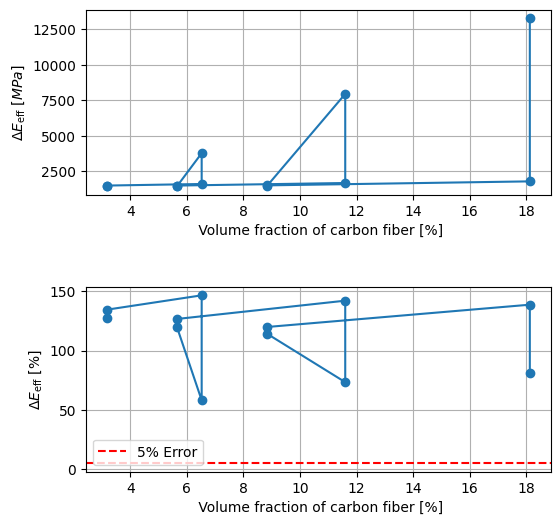

In [46]:
# error 

error = np.abs(np.array(E_eff_analytical) - np.array(E_eff))
plt.figure( figsize=(6,6) )
# padding subplot h=0.5
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,1,1)
plt.plot(100*v_carbon,error,"o-")

plt.ylabel(r"$\Delta E_{\text{eff}} \ [MPa]$")
plt.xlabel(" Volume fraction of carbon fiber [%]")
plt.grid()

plt.subplot(2,1,2)
error_rel = error / np.array(E_eff)

plt.plot(100*v_carbon,100*error_rel,"o-")
plt.axhline(y=5, color='r', linestyle='--', label='5% Error')

# 
plt.ylabel(r"$\Delta E_{\text{eff}} \ [\%]$")
plt.xlabel(" Volume fraction of carbon fiber [%]")
plt.grid()
plt.legend()



In [47]:
import pandas as pd
df_save = pd.DataFrame({"vfrac":vfrac_FEM,"E":E_eff})
df_save.to_csv("E_eff_analytical.csv",index=False)

NameError: name 'vfrac_FEM' is not defined